In [14]:
# import modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from luc_crime_fncs import cleaner, gps_to_merc, find_all_address
from bokeh.plotting import figure, show, output_notebook
from bokeh.tile_providers import get_provider, Vendors
from bokeh.models import ColumnDataSource

In [15]:
# creating a sample DF of chicago crime dataset

originalPath = 'C:/Users/agarc/CrimeAnalyses/ChicagoCrime/DataSets/crimes_2022.csv'
starting_df = pd.read_csv(originalPath)

# n = 500
# starting_df = sampleDF(originalPath, n)

starting_df.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,12766270,JF323407,07/17/2022 12:30:00 PM,039XX W 62ND ST,0820,THEFT,$500 AND UNDER,RESIDENCE - YARD (FRONT / BACK),False,False,...,23.0,65,06,NaN,NaN,2022,07/24/2022 04:49:35 PM,NaN,NaN,NaN
1,12765091,JF321809,07/17/2022 11:15:00 AM,001XX W MADISON ST,1320,CRIMINAL DAMAGE,TO VEHICLE,PARKING LOT / GARAGE (NON RESIDENTIAL),False,False,...,42.0,32,14,NaN,NaN,2022,07/24/2022 04:49:35 PM,NaN,NaN,NaN
2,12766260,JF323206,07/17/2022 07:08:00 PM,032XX W BELMONT AVE,0860,THEFT,RETAIL THEFT,DEPARTMENT STORE,False,False,...,35.0,21,06,NaN,NaN,2022,07/24/2022 04:49:35 PM,NaN,NaN,NaN
3,12763575,JF320436,07/17/2022 03:46:00 AM,0000X W CONGRESS PKWY,0820,THEFT,$500 AND UNDER,GAS STATION,False,False,...,4.0,32,06,NaN,NaN,2022,07/24/2022 04:49:35 PM,NaN,NaN,NaN
4,12767451,JF324492,07/17/2022 05:00:00 PM,014XX S SACRAMENTO DR,0820,THEFT,$500 AND UNDER,PARK PROPERTY,False,False,...,24.0,29,06,NaN,NaN,2022,07/24/2022 04:49:35 PM,NaN,NaN,NaN


In [16]:
# cleaning up column names; updates starting_df
cleaner(starting_df, lower=True, dropna=True)

# removes speficied columns
main_df = starting_df.drop(columns=['id', 'case_number', 'iucr', 'location_description', 'arrest',
                             'domestic', 'ward', 'fbi_code', 'x_coordinate', 'y_coordinate',
                             'beat', 'district', 'community_area', 'year', 'updated_on', 
                             'latitude', 'longitude']) 
main_df.head()

print('main_df length:', len(main_df))

main_df['location'].value_counts() # checking if mulitple crimes occur in at coords

main_df length: 150389


(41.884335468, -87.619164088)    251
(41.976290414, -87.905227221)    204
(41.883500187, -87.627876698)    176
(41.788987036, -87.74147999)     150
(41.903304304, -87.670064675)    147
                                ... 
(41.943636516, -87.648158478)      1
(41.87926429, -87.743945195)       1
(41.857888856, -87.660468787)      1
(41.763105901, -87.66262925)       1
(41.940024836, -87.645355963)      1
Name: location, Length: 84155, dtype: int64

In [17]:
# passing location val to gps_to_merc and populating new col with returned val
# anonymous fnc is needed as apply() only takes fncs invoked w/out parentheses

main_df['xCoords'] = main_df['location'].apply(lambda x : gps_to_merc(x)[0])
main_df['yCoords'] = main_df['location'].apply(lambda x : gps_to_merc(x)[1])
print(len(main_df))
main_df.head()

150389


,date,block,primary_type,description,location,xCoords,yCoords
5,07/14/2022 11:00:00 PM,002XX E RANDOLPH ST,CRIMINAL DAMAGE,TO VEHICLE,"(41.884276844, -87.622098929)",-9.754047e+06,5.143660e+06
6,06/20/2022 06:30:00 PM,068XX N SEELEY AVE,OFFENSE INVOLVING CHILDREN,CHILD ABUSE,"(42.005679058, -87.681913036)",-9.760706e+06,5.161830e+06
7,01/21/2022 09:30:00 PM,080XX S ESSEX AVE,MOTOR VEHICLE THEFT,AUTOMOBILE,"(41.749253201, -87.563762808)",-9.747553e+06,5.123492e+06
8,01/27/2022 09:10:00 PM,012XX W 87TH ST,ASSAULT,SIMPLE,"(41.73590915, -87.655034981)",-9.757714e+06,5.121502e+06
9,01/27/2022 04:00:00 PM,041XX W MADISON ST,THEFT,OVER $500,"(41.88068906, -87.728733158)",-9.765918e+06,5.143124e+06


In [18]:
# groups data by (location, primary_type, description) values and applies count fnc
crime_freq_by_coords = main_df.groupby(['location', 'primary_type', 'description']).count().reset_index()

# drop columns to avoid duplicate cols after merger in the next cell 
crime_freq_by_coords.drop(columns=['date', 
                                'block', 
                                'description', 
                                'yCoords', 
                                'primary_type'], inplace=True)

# renames col for clairity
crime_freq_by_coords.rename(columns={'xCoords':'crime_freq'}, inplace=True)
print('crime_freq_by_coords length:', len(crime_freq_by_coords))
crime_freq_by_coords.head()

crime_freq_by_coords length: 128731


,location,crime_freq
0,"(41.644595158, -87.596781458)",1
1,"(41.644608279, -87.613581972)",1
2,"(41.644612024, -87.601570479)",1
3,"(41.645287658, -87.540012254)",1
4,"(41.645287658, -87.540012254)",1


In [19]:
# inner merge crime_freq_by_coords and main_df together on location column
crime_freq_df = pd.merge(main_df, crime_freq_by_coords, on='location', how='inner')
crime_freq_df.drop_duplicates(subset=['location', 'primary_type', 'description'], inplace=True)
print('crime_freq_df length:', len(crime_freq_df))
crime_freq_df.head()

crime_freq_df length: 128731


,date,block,primary_type,description,location,xCoords,yCoords,crime_freq
0,07/14/2022 11:00:00 PM,002XX E RANDOLPH ST,CRIMINAL DAMAGE,TO VEHICLE,"(41.884276844, -87.622098929)",-9.754047e+06,5.143660e+06,1
14,01/29/2022 05:00:00 PM,002XX E RANDOLPH ST,THEFT,$500 AND UNDER,"(41.884276844, -87.622098929)",-9.754047e+06,5.143660e+06,1
42,02/21/2022 08:00:00 PM,002XX E RANDOLPH ST,BATTERY,AGGRAVATED - OTHER DANGEROUS WEAPON,"(41.884276844, -87.622098929)",-9.754047e+06,5.143660e+06,1
56,02/21/2022 10:00:00 AM,002XX E RANDOLPH ST,THEFT,OVER $500,"(41.884276844, -87.622098929)",-9.754047e+06,5.143660e+06,1
70,04/02/2022 08:30:00 AM,002XX E RANDOLPH ST,THEFT,POCKET-PICKING,"(41.884276844, -87.622098929)",-9.754047e+06,5.143660e+06,1


In [20]:
# assigning glyph size based on crime_freq; if freq <= 17, then size is freq + 3;
# if freq > 17, then size is 30
glyph_sizes = [freq + 3 if freq <= 17 else 30 for freq in crime_freq_df['crime_freq']]

crime_freq_df['glyph_size'] = glyph_sizes # new col for glyph sizes
crime_freq_df.head()

,date,block,primary_type,description,location,xCoords,yCoords,crime_freq,glyph_size
0,07/14/2022 11:00:00 PM,002XX E RANDOLPH ST,CRIMINAL DAMAGE,TO VEHICLE,"(41.884276844, -87.622098929)",-9.754047e+06,5.143660e+06,1,4
14,01/29/2022 05:00:00 PM,002XX E RANDOLPH ST,THEFT,$500 AND UNDER,"(41.884276844, -87.622098929)",-9.754047e+06,5.143660e+06,1,4
42,02/21/2022 08:00:00 PM,002XX E RANDOLPH ST,BATTERY,AGGRAVATED - OTHER DANGEROUS WEAPON,"(41.884276844, -87.622098929)",-9.754047e+06,5.143660e+06,1,4
56,02/21/2022 10:00:00 AM,002XX E RANDOLPH ST,THEFT,OVER $500,"(41.884276844, -87.622098929)",-9.754047e+06,5.143660e+06,1,4
70,04/02/2022 08:30:00 AM,002XX E RANDOLPH ST,THEFT,POCKET-PICKING,"(41.884276844, -87.622098929)",-9.754047e+06,5.143660e+06,1,4


In [21]:
for_bokeh_df = crime_freq_df.copy()

In [22]:
# north/south bound streets with home number between 56XX to 72XX
northStreets = ['N KENMORE AVE', 'N WINTHROP AVE', 'N ARTHUR AVE', 'N SHERIDAN RD', 
                'N LAKEWOOD AVE', 'N MAGNOLIA AVE', 'N GLENWOOD AVE', 'N NEWGARD AVE'
                'N GREENVIEW AVE', 'N BOSWORTH AVE', 'N ASHLAND AVE', 'N CLARK ST',
                'N RAVENSWOOD AVE', 'N RIDGE AVE', 'N RIDGE BLVD', 'N WOLCOTT AVE', 
                'N WAYNE AVE', 'N BROADWAY', 'N PAULINA ST', 'N HERMITAGE AVE', 'N DAMEN']

# west/east bound streets with home number less than or equal to 19XX
westStreets = ['W LOYOLA AVE', 'W SHERIDAN RD', 'W ROSEMONT AVE', 'W GRANVILLE AVE',
               'W ALBION AVE', 'W NORTH SHORE AVE', 'NEIL HARTIGAN AVE', 'W COLUMBIA AVE', 
               'W PRATT BLVD', 'W FARWELL AVE', 'W MORSE AVE', 'W LUNT AVE', 
               'W GREENLEAF AVE', 'W ESTES AVE', 'W TOUHY AVE', 'W CHASE AVE', 
               'W GLENLAKE AVE', 'W THORNDALE AVE', 'W ARDMORE AVE', 'W HOLLYWOOD AVE',
               'W BRYN MAWR AVE', 'W VICTORIA ST', 'W EARLY AVE', 'W OLIVE AVE',
               'W DEVON AVE', 'W HIGHLAND AVE', 'W THOME AVE', 'W SCHREIBER', 
               'W WALLEN AVE', 'W HOOD AVE', 'W NORWOOD AVE']

# list of addresses around LUC where crimes occurred
luc_addresses = find_all_address(crime_freq_df, addressCol='block', horiSt=westStreets, vertSt=northStreets)

# makes DF of bool values indicating whether a luc_addresses item is in a given cell
bool_df = for_bokeh_df.isin(luc_addresses)

# making to avoiding updating for_bokeh_df
for_bokeh_df_copy = for_bokeh_df.copy() 

# adds new column, bool_block to for_bokeh_df_copy
for_bokeh_df_copy['bool_block'] = bool_df['block']

# makes new DF, luc_crime_df, which contains only rows that have True as value for bool_block
luc_crime_df = for_bokeh_df_copy[for_bokeh_df_copy['bool_block'] == True]
luc_crime_df.head()

,date,block,primary_type,description,location,xCoords,yCoords,crime_freq,glyph_size,bool_block
2616,03/16/2022 10:00:00 PM,064XX N DAMEN AVE,THEFT,OVER $500,"(41.998589094, -87.68016062)",-9.760511e+06,5.160768e+06,1,4,True
12033,03/24/2022 01:28:00 PM,016XX W GREENLEAF AVE,OTHER OFFENSE,HARASSMENT BY TELEPHONE,"(42.010254985, -87.671122009)",-9.759505e+06,5.162516e+06,1,4,True
12039,03/25/2022 10:00:00 PM,016XX W GREENLEAF AVE,BATTERY,DOMESTIC BATTERY SIMPLE,"(42.010254985, -87.671122009)",-9.759505e+06,5.162516e+06,1,4,True
12045,03/24/2022 08:00:00 PM,016XX W GREENLEAF AVE,CRIMINAL DAMAGE,TO VEHICLE,"(42.010254985, -87.671122009)",-9.759505e+06,5.162516e+06,1,4,True
12051,03/24/2022 02:00:00 PM,016XX W GREENLEAF AVE,ASSAULT,SIMPLE,"(42.010254985, -87.671122009)",-9.759505e+06,5.162516e+06,1,4,True


In [23]:
# following 2 lines are used to create a Bokeh data structure called ColumnDataStructure (CDS)
# CSD is needed to provide data to glyphs
cds_dict = {'xAxis':list(luc_crime_df['xCoords']), 
           'yAxis':list(luc_crime_df['yCoords']), 
           'PrimaryDescription':list(luc_crime_df['primary_type']),
           'SecondaryDescription':list(luc_crime_df['description']),
           'Freq':list(luc_crime_df['crime_freq']), 
           'Date':list(luc_crime_df['date']), 
           'circleSize':list(luc_crime_df['glyph_size']), 
           'Location':list(luc_crime_df['location']), 
           'Block':list(luc_crime_df['block'])}

# dict is passed to fnc that creates a CDS
source = ColumnDataSource(data=cds_dict)
print(source)

# this is how to choose the info that is displayed when hovering over glyph
hoverTool = [('Crime Type', '@PrimaryDescription'), ('Specific Type', '@SecondaryDescription'), 
             ('Frequency', '@Freq' ), ('Date/Time', '@Date'), 
             ('Block', '@Block'), ('-----------','')]

# generates Bokeh Figure
p = figure(x_axis_type = 'mercator', y_axis_type = 'mercator', tooltips=hoverTool)

# retrieves an instance of a tile provider
map_provider = get_provider(Vendors.CARTODBPOSITRON)

# adds the chosen tile provider to the plot.
p.add_tile(map_provider)

# creates glyphs on the plot and is used for customizing them
p.circle(x='xAxis', y='yAxis', source=source, 
         size='circleSize', fill_alpha= 0.20, 
         line_color='red', fill_color='red')

output_notebook()
show(p)

ColumnDataSource(id='1120', ...)


Loading BokehJS ...

In [24]:
near_luc = find_all_address(main_df, addressCol='block', horiSt=westStreets, vertSt=northStreets)

# makes DF of bool values indicating whether a luc_addresses item is in a given cell
bool_df = main_df.isin(near_luc)

# making to avoiding updating for_bokeh_df
crime_df_copy = main_df.copy() 

# adds new column, bool_block to for_bokeh_df_copy
crime_df_copy['bool_block'] = bool_df['block']

# makes new DF, luc_crime_df, which contains only rows that have True as value for bool_block
for_graph_df = crime_df_copy[crime_df_copy['bool_block'] == True]
for_graph_df.head()

,date,block,primary_type,description,location,xCoords,yCoords,bool_block
92,03/16/2022 10:00:00 PM,064XX N DAMEN AVE,THEFT,OVER $500,"(41.998589094, -87.68016062)",-9.760511e+06,5.160768e+06,True
175,03/24/2022 01:28:00 PM,016XX W GREENLEAF AVE,OTHER OFFENSE,HARASSMENT BY TELEPHONE,"(42.010254985, -87.671122009)",-9.759505e+06,5.162516e+06,True
224,03/07/2022 03:00:00 PM,057XX N WINTHROP AVE,DECEPTIVE PRACTICE,CREDIT CARD FRAUD,"(41.986107062, -87.658094107)",-9.758054e+06,5.158899e+06,True
260,04/06/2022 12:00:00 AM,065XX N ASHLAND AVE,CRIMINAL DAMAGE,TO PROPERTY,"(42.000800221, -87.670465853)",-9.759432e+06,5.161099e+06,True
372,04/03/2022 07:20:00 AM,061XX N BROADWAY,THEFT,RETAIL THEFT,"(41.993043969, -87.660360363)",-9.758307e+06,5.159938e+06,True


In [25]:
crime_freq_graph_df = for_graph_df['primary_type'].value_counts().reset_index(name='crime_freq')
crime_freq_graph_df.head()

,index,crime_freq
0,THEFT,693
1,BATTERY,522
2,CRIMINAL DAMAGE,273
3,ASSAULT,242
4,OTHER OFFENSE,180


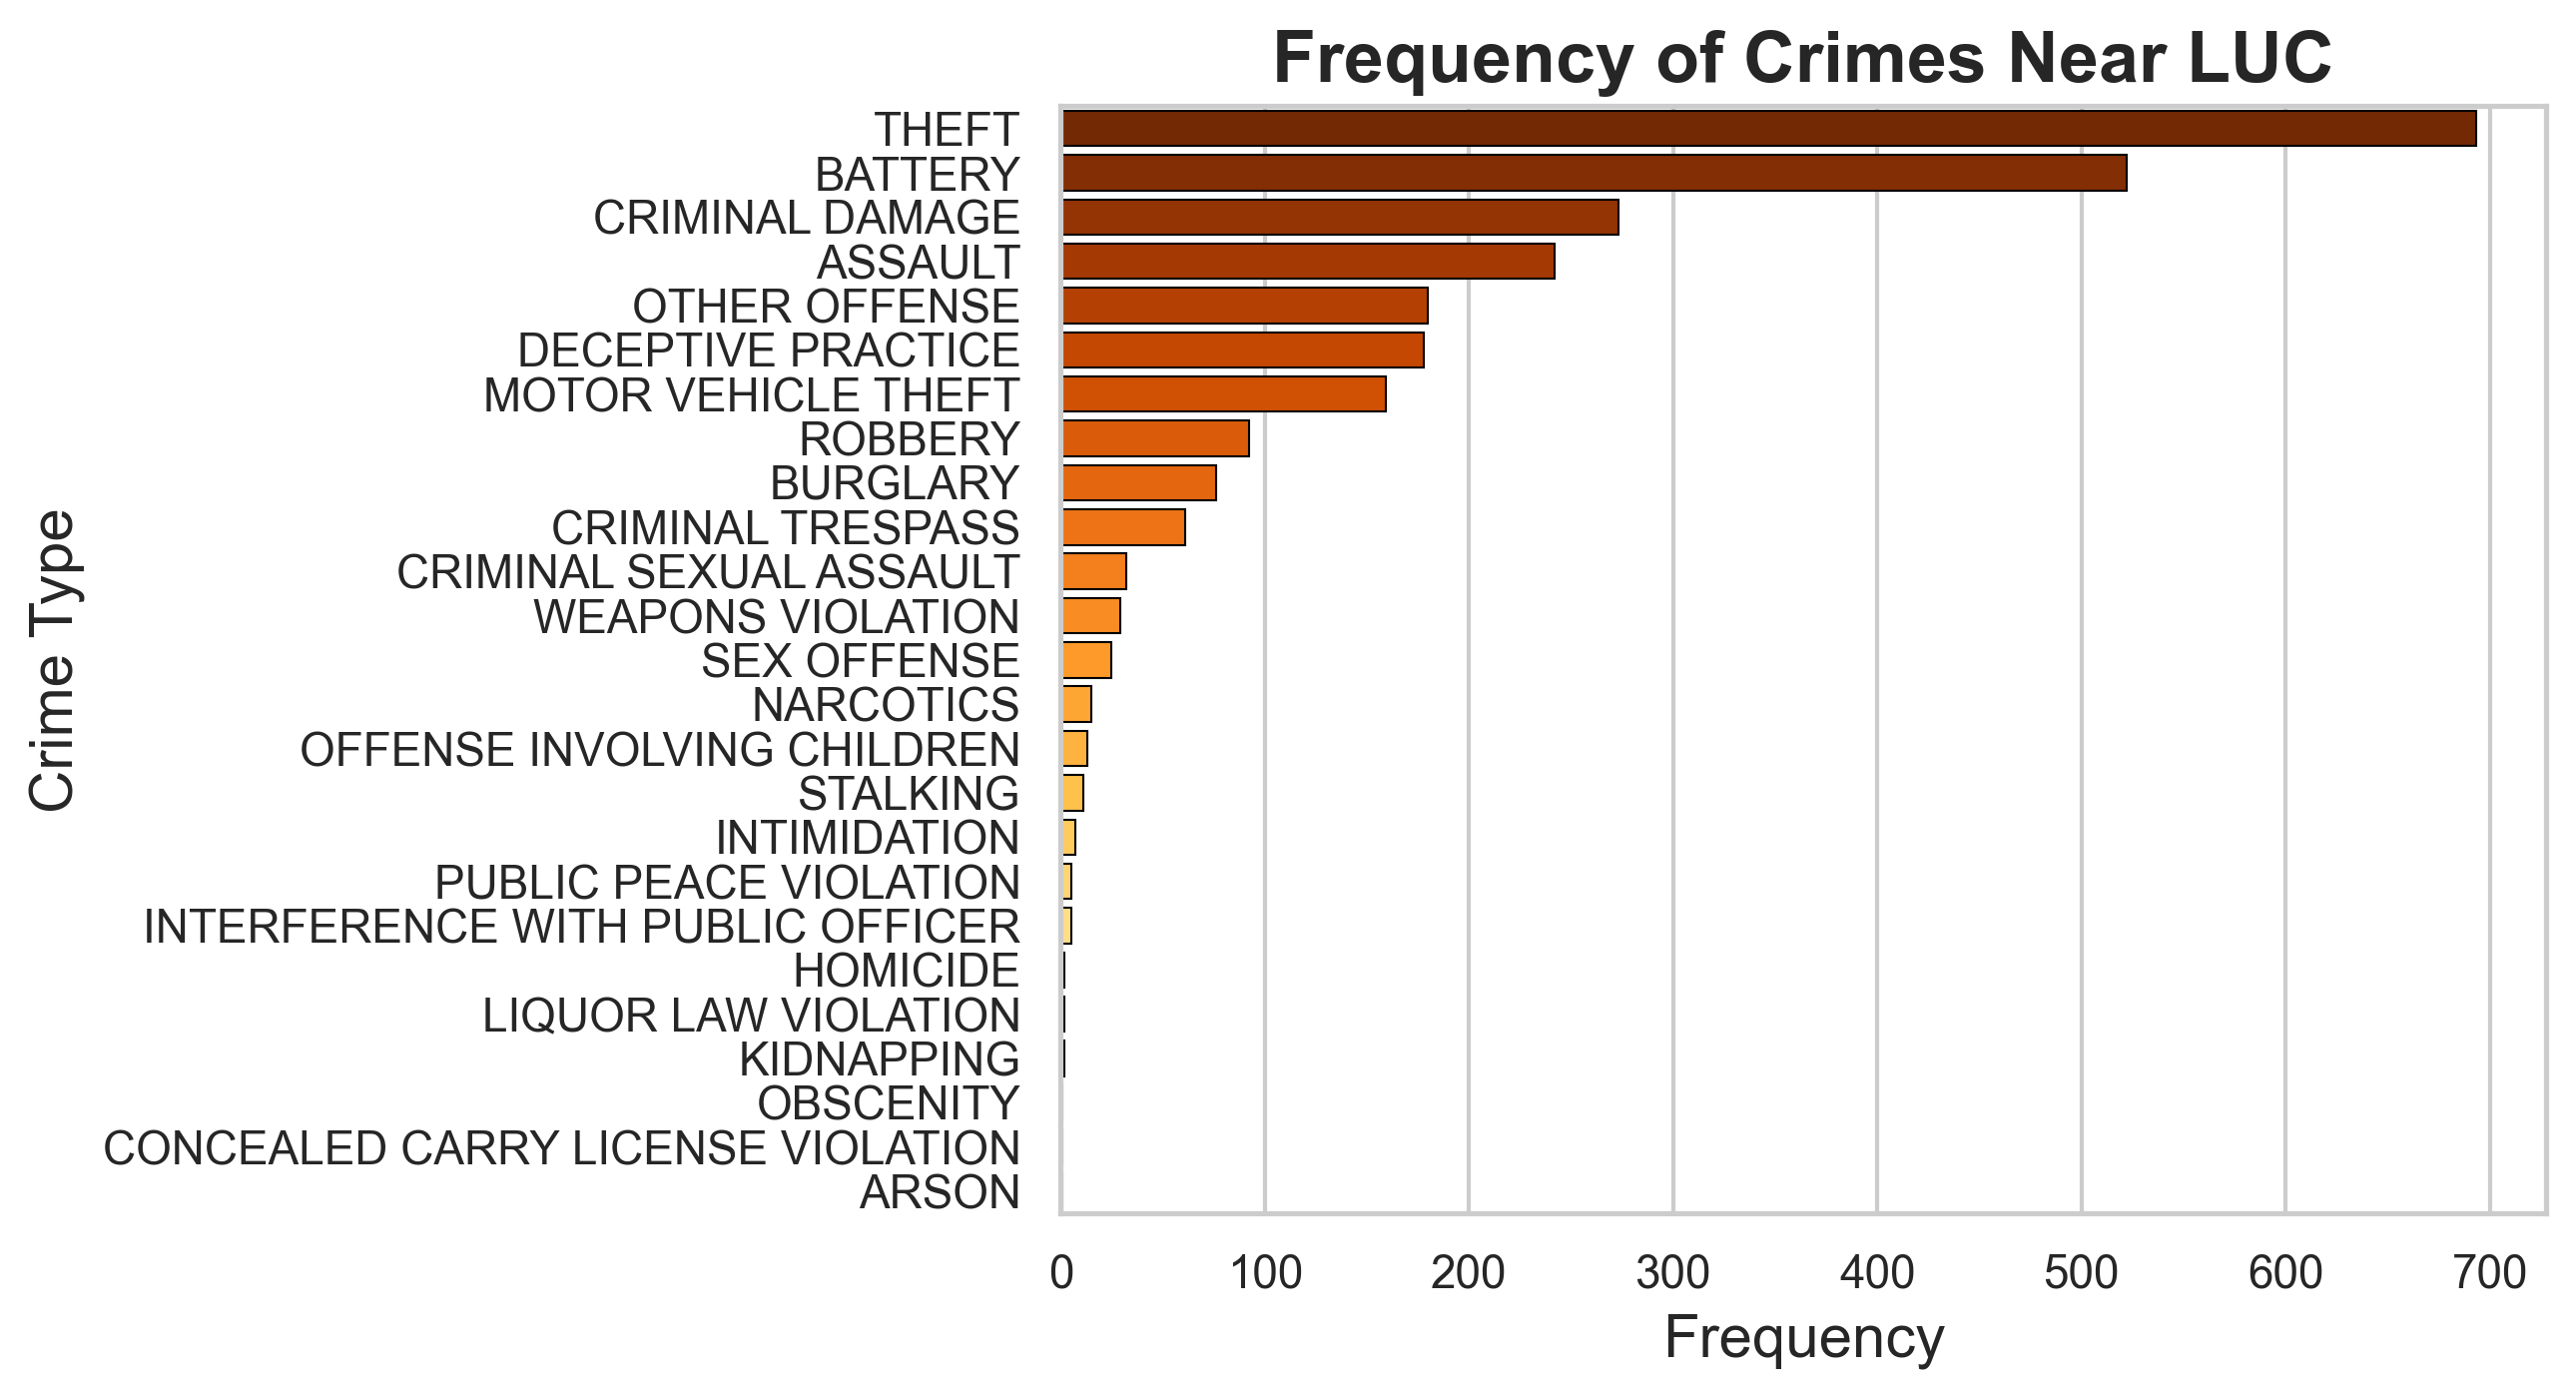

In [26]:
# sets background of graph
sns.set_theme(style='whitegrid', palette='pastel')

# creates default bar graph based on given arguments
bar_graph = sns.barplot(y="index", x="crime_freq", data=crime_freq_graph_df, 
                 edgecolor='black', linewidth=.5, saturation=4,
                 palette='YlOrBr_r')

# following 3 lines change the axes names adds a title
bar_graph.set_xlabel('Frequency', size='large')
bar_graph.set_ylabel('Crime Type', size='large')
bar_graph.set_title('Frequency of Crimes Near LUC', weight='bold', size='x-large') #make bold and x-large

# increases resolution of graph
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
plt.show()